In [1]:

from pprint import pprint
from utils import *
import matplotlib.pyplot as plt
from types import SimpleNamespace
from datetime import datetime
import numpy as np 
import itertools
import pandas as pd
from functools import reduce
from tqdm import tqdm

def remove_axis_ticks(ax):
    ax.set_xticklabels([])
    ax.set_yticklabels([]) 
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)


In [2]:
# COMPUTE INTERVALS FOR EACH INDIVIDUAL FOR EACH TASK AND SAVE TO DISK
datasets = get_clean_datasets()
print(f"Using participants: {list(datasets.keys())}")
save_data = dict()

#datasets = get_clean_datasets(n=1)
for participant, _datasets in tqdm(datasets.items()):
    save_data[participant] = dict()
    for experiment, dataset in _datasets.items():
        start_time, finish_time = LineData.get_start_time(dataset), LineData.get_finish_time(dataset)
        # save the start and end times of the runs
        save_data[participant][experiment] = dict(start_time = start_time, finish_time = finish_time)
        for task, properties in ALL_WINDOW_PROPERTIES.items():
            data = properties['data_fn'](dataset) # get data for this task
            # COMPUTE STATISTICS: failure intervals for each task.
            intervals = [compute_time_intervals(x.failure, x.timestamp, data.start_time, data.finish_time).intervals for x in data.components.values()]
            save_data[participant][experiment][task] = dict()
            save_data[participant][experiment][task]['failure_intervals'] = merge_intervals(intervals)
            
save_nested_dict(save_data, 'data/Processed')


loading files...: 104it [00:42,  2.45it/s]


Using participants: ['P00', 'P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P16', 'P17', 'P18', 'P23', 'P24', 'P25']


100%|███████████████████████████████████████████| 17/17 [00:08<00:00,  2.01it/s]


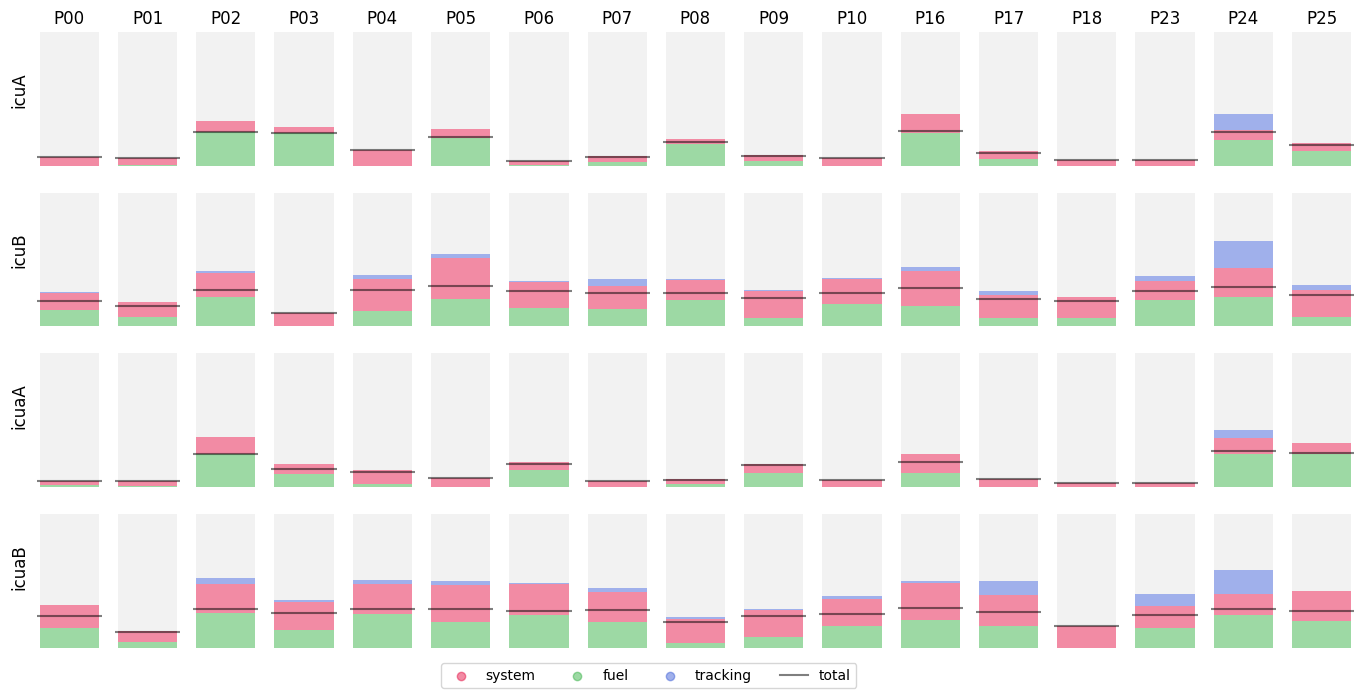

In [253]:
# PLOT PROPORTION OF TIME IN FAILURE FOR ALL PARTICIPANTS
data = load_nested_dict('data/Processed') 

fig, axes = plt.subplots(ncols=len(data.items()), nrows=4, figsize=(17,8))

alpha = 0.5
total_color = "black"

for (participant, _data1), _axes in zip(data.items(), axes.T):
    for (experiment, _data2), ax in zip(_data1.items(), _axes):
        ax.axis('off')
        #ax.set_title(experiment) # sanity check
        prop_scale = 3
        ax.set_ylim(0,prop_scale) # this is three because the proportion if shown for each task (3 tasks)
        # plot failure proportions
        failure_proportions = []
        for k, failure_intervals in [(k,v['failure_intervals']) for k,v in _data2.items() if isinstance(v,dict)]: 
            failure_proportion = Statistics.compute_failure_proportion([failure_intervals], _data2['start_time'], _data2['finish_time'])
            ax.bar(0, failure_proportion, bottom=sum(failure_proportions), width=1, align='center', alpha=alpha, color=ALL_WINDOW_PROPERTIES[k]['color'])
            failure_proportions.append(failure_proportion)
        #print(experiment, failure_proportions)
        
        ax.bar(0, prop_scale-sum(failure_proportions), bottom=sum(failure_proportions), width=1, align='center', alpha=0.05,color='black')
        # total time in failure
        total_failure = merge_intervals([v['failure_intervals'] for v in _data2.values() if isinstance(v,dict)])
        total_failure_proportion = Statistics.compute_failure_proportion([total_failure], _data2['start_time'], _data2['finish_time'])
        ax.axhline(y=total_failure_proportion, color=total_color, alpha=alpha)
          
for ax, par in zip(axes[0,:], data.keys()):
    ax.set_title(par)

for ax, par in zip(axes[:,0], data['P01'].keys()):
    ax.text(-1, 1.4, par[3:], rotation='vertical', size='large')
    
for k,v in ALL_WINDOW_PROPERTIES.items():
    plt.gca().scatter([],[], label=k, color=v['color'], alpha=alpha) # for legend purposes
plt.gca().plot([],[], label='total', color=total_color, alpha=alpha)
    
plt.legend(loc=(-13,-0.3), ncols=len(ALL_WINDOW_PROPERTIES)+1)


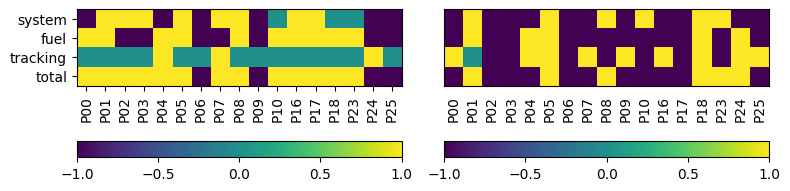

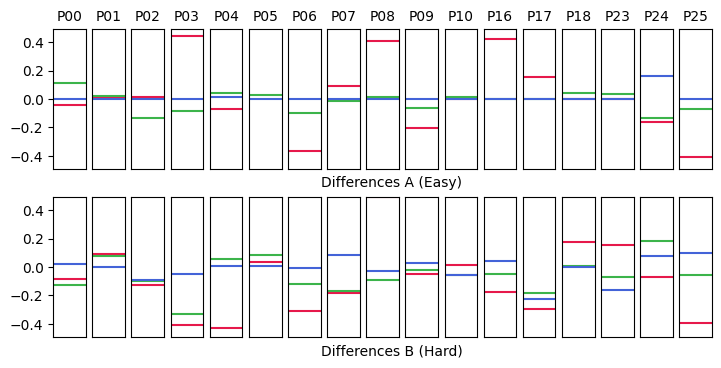

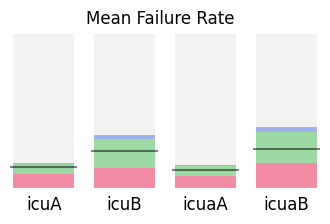

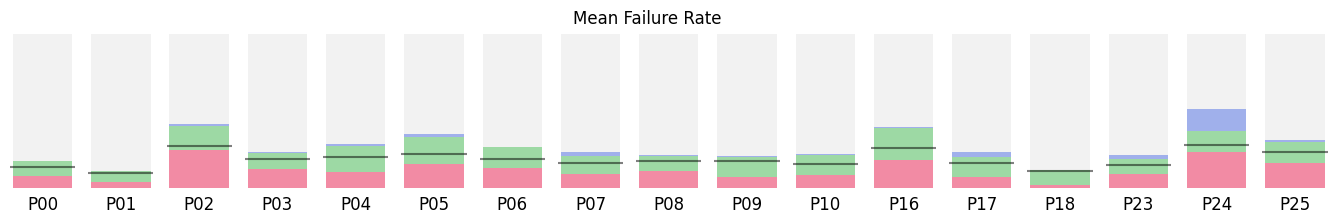

In [252]:
# PLOT STATISTICS FOR TIME IN FAILURE

df = pd.DataFrame(columns=['participant', 'experiment', *ALL_WINDOW_PROPERTIES.keys(), 'total'])

for participant, _data1 in data.items():
    for experiment, _data2 in _data1.items():
        #print(experiment)
        failure_proportions = []
        for k, failure_intervals in [(k,v['failure_intervals']) for k,v in _data2.items() if isinstance(v,dict)]: 
            failure_proportion = Statistics.compute_failure_proportion([failure_intervals], _data2['start_time'], _data2['finish_time'])
            failure_proportions.append(failure_proportion)
        total_failure = merge_intervals([v['failure_intervals'] for v in _data2.values() if isinstance(v,dict)])
        total_failure_proportion = Statistics.compute_failure_proportion([total_failure], _data2['start_time'], _data2['finish_time'])
        df.loc[len(df)] = [participant, experiment[3:], *failure_proportions, total_failure_proportion]

        
        
def plot_mean(df, groupby, total_color = "black"):
    data = df.select_dtypes(include='float').groupby(groupby)
    fig, axes = plt.subplots(ncols=len(data), nrows=1, figsize=(len(data),2))
    fig.suptitle("Mean Failure Rate", y=1)
    _axes = iter(axes.ravel())
    for (indx, mu), (_, sigma) in zip(data.mean().iterrows(), data.std().iterrows()):
        ax = next(_axes)
        ax.axis('off')
        prop_scale = 3
        ax.set_ylim(0,prop_scale) 
        for i, (k, v) in enumerate(zip(mu.keys()[:-1], mu.values[:-1])):
            ax.bar(0, v, bottom=sum(mu.values[:i]), width=1, align='center', alpha=alpha, color=ALL_WINDOW_PROPERTIES[k]['color'])
        ax.bar(0, prop_scale-sum(mu.values[:-1]), bottom=sum(mu.values[:-1]), width=1, align='center', alpha=0.05,color='black')
        ax.axhline(y=mu.values[-1], color=total_color, alpha=alpha)
        ax.set_title(indx,y=-0.2)

def plot_differences(df, groupby, alpha=1):
    grouped = df.select_dtypes(include='float').groupby(groupby)
    data = {name:group.values for name,group in grouped}
    # if this is negative, the agents did bad.
    difA = data['icuA'] - data['icuaA'] # icua should have a LOWER failure proportion.
    difB = data['icuB'] - data['icuaB'] # icua should have a LOWER failure proportion.

    fig, axes = plt.subplots(ncols=len(difA), nrows=2, figsize=(len(difA)/2,4), sharey=True)
    #fig.suptitle("Differences")
    ylima = max(abs(np.min(difA)), abs(np.max(difA)))
    ylimb = max(abs(np.min(difB)), abs(np.max(difB)))
    for (A,B,(axa, axb)) in zip(difA, difB, axes.T):
        axa.set_xticklabels([]),  axb.set_xticklabels([])
        axa.tick_params(axis='both', which='both', bottom=False, top=False,left=False,right=False)
        axb.tick_params(axis='both', which='both', bottom=False, top=False,left=False,right=False)
        prop_scale = 3
        axa.set_ylim(-ylima, ylima), axb.set_ylim(-ylimb, ylimb)
        
        #axa.set_ylim(0,prop_scale), axb.set_ylim(0,prop_scale) 
        for i,(k, a, b) in enumerate(zip(df.select_dtypes(include='float').columns[:-1], A[:-1],B[:-1])):
            axa.axhline(y=a, color=ALL_WINDOW_PROPERTIES[k]['color'], alpha=alpha)
            axb.axhline(y=b, color=ALL_WINDOW_PROPERTIES[k]['color'], alpha=alpha)
    axes[0,0].tick_params(left=True)
    axes[1,0].tick_params(left=True)
    axes[0,axes.shape[1]//2].text(-1.4,-0.62,"Differences A (Easy)")
    axes[1,axes.shape[1]//2].text(-1.4,-0.62,"Differences B (Hard)")
    for ax, par in zip(axes[0], df['participant'].unique()):
        ax.set_title(par, size="medium")  
        

def plot_performance(df):
    grouped = df.select_dtypes(include='float').groupby(df['experiment'])
    data = {name:group.values for name,group in grouped}
    
    def _plot(k1, k2, ax, showbar=False):
        dif = data[k2] - data[k1] # icua should have a LOWER failure proportion.
        indx = (np.where(dif < 0, -1, np.where(dif > 0, 1, 0))).astype(int)
        im = ax.imshow(indx.T)
        fig.colorbar(im, location="bottom") 
        
        
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
    axA, axB = axes.ravel()
    
    _plot('icuaA', 'icuA', axA)
    _plot('icuaB', 'icuB', axB, showbar=True)
    axA.set_yticks(np.arange(len(df.columns[2:])), df.columns[2:])
    pars = df['participant'].unique()
    axA.set_xticks(np.arange(len(pars)), pars, rotation=90)
    
    
    axB.tick_params(axis='both', which='both', bottom=False,top=False,left=False,right=False)
    axB.set_yticks([],[])
    axB.set_xticks(np.arange(len(pars)), pars, rotation=90)
    
    fig.tight_layout()
    
plot_performance(df)


plot_differences(df, df['experiment'])
plot_stats(df, df['experiment'])
plot_stats(df, df['participant'])




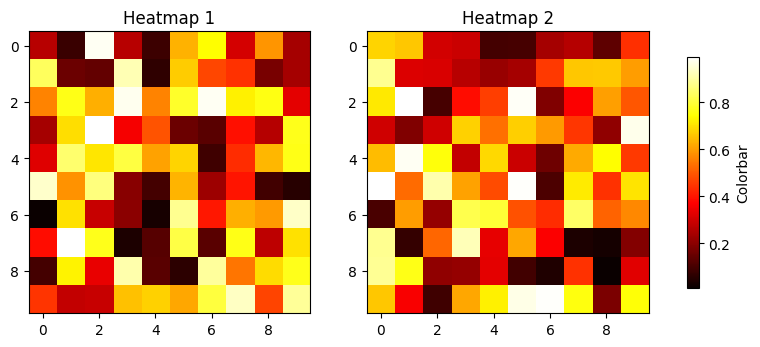

In [208]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
data1 = np.random.rand(10, 10)  # 10x10 random values
data2 = np.random.rand(10, 10)  # 10x10 random values

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot heatmap 1
heatmap1 = axes[0].imshow(data1, cmap='hot')
axes[0].set_title('Heatmap 1')

# Plot heatmap 2
heatmap2 = axes[1].imshow(data2, cmap='hot')
axes[1].set_title('Heatmap 2')

# Create colorbar
cbar = fig.colorbar(heatmap2, ax=axes.ravel().tolist(), shrink=0.6)
cbar.set_label('Colorbar')

# Show the plot
plt.show()

In [ ]:
data = load_nested_dict('data/Processed') 

def plot_intervals(intervals, ax, alpha=0.25, color='red'):
    for interval in intervals:
        ax.axvspan(*interval, alpha=alpha, color=color, linewidth=0)

def plot_failure_intervals(data):
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12,4))
    _axes = iter(axes.ravel())
    for task, _data2 in _data1.items():
        ax = next(_axes)
        ax.axis('off')
        for i, (k, failure_intervals) in enumerate([(k,v['failure_intervals']) for k,v in _data2.items() if isinstance(v,dict)]): 
            plot_intervals(failure_intervals, ax, color=ALL_WINDOW_PROPERTIES[k]['color'])
            ax.set_xlim(_data2['start_time'], _data2['finish_time'])
        total_failure = merge_intervals([v['failure_intervals'] for v in _data2.values() if isinstance(v,dict)])
        
        plot_intervals(total_failure, ax, color="grey")
        
        
for participant, _data1 in data.items():
    print(participant)
    plot_failure_intervals(_data1)
    break

In [ ]:
plt.figure()
x = np.linspace(0,1)
y = 0
for color in plt.rcParams['axes.prop_cycle']:
    y += 0.1
    plt.gca().plot(x, y + np.sin(x), color=color['color'])